In [14]:
import os
import numpy as np
import pandas as pd
from copy import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import scanpy as sc
import phate

In [2]:
import scanpy as sc
ppath = '/stanley/WangLab/Connie/02.TEMPOmap/03.revision1000Gene'
adata = sc.read_h5ad(os.path.join(ppath, 'adata', '2022-10-21-TEMPOrevision1000Gene-filtered.h5ad'))
adata

AnnData object with n_obs × n_vars = 14359 × 998
    obs: 'orig_index', 'sample', 'volume', 'x', 'y', 'z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Fluo', 'mKO2', 'mKO', 'mAG', 'nuclei_volume', 'sc_norm_total_wo_anchor', 'nucl_pct', 'filter_cell_vol', 'filter_nucl_vol', 'filter_counts', 'filter'

In [3]:
sample_list = np.unique(adata.obs['sample'])
n_samples = len(sample_list)
sample_list

array(['1h_labeling', '1h_labeling_1h_wash', '1h_labeling_2h_wash',
       '1h_labeling_4h_wash', '1h_labeling_6h_wash', '20h_labeling',
       'STARmap'], dtype=object)

In [4]:
# anchor genes
_anchor = pd.read_csv(os.path.join(ppath, '1000-gene HeLa dataset anchor gene.csv'))
anchor = _anchor['Anchor gene'].values
anchor

array(['YTHDF1', 'YTHDF2', 'YTHDF3', 'YTHDC1', 'YTHDC2', 'METTL14',
       'METTL3'], dtype=object)

In [5]:
sample_adata = dict()
for sample in sample_list:
    curr_adata = sc.read_h5ad(os.path.join(ppath, 'adata', f'TEMPO-1000gene-flt-{sample}.h5ad'))
    sample_adata[sample] = curr_adata
#     sc.pp.neighbors(curr_adata, metric='euclidean', n_neighbors=15)
#     sc.tl.umap(curr_adata, min_dist=0.5)
#     sc.pl.umap(curr_adata, color='sample')
#     sc.pl.umap(curr_adata, color='phase_ref', palette={'G1': 'rebeccapurple', 'G2M': 'mediumaquamarine', 'S': 'gold'})
# NOTE when in merged adata, preprocessing is done on entire adata --> genes scaled across samples ??? 

In [6]:
adata_ = adata[:,np.isin(adata.var.index, anchor, invert=True)]
adata_ = adata_[np.logical_and(adata_.obs['sample']!='20h_labeling', adata_.obs['sample']!='STARmap')]
adata_

View of AnnData object with n_obs × n_vars = 11076 × 991
    obs: 'orig_index', 'sample', 'volume', 'x', 'y', 'z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Fluo', 'mKO2', 'mKO', 'mAG', 'nuclei_volume', 'sc_norm_total_wo_anchor', 'nucl_pct', 'filter_cell_vol', 'filter_nucl_vol', 'filter_counts', 'filter'

In [7]:
np.unique(adata_.obs['sample'], return_counts=True)

(array(['1h_labeling', '1h_labeling_1h_wash', '1h_labeling_2h_wash',
        '1h_labeling_4h_wash', '1h_labeling_6h_wash'], dtype=object),
 array([2090, 2062, 1966, 2085, 2873]))

In [8]:
merged_cc = []
for i in range(adata_.n_obs):
    s = adata_.obs.iloc[i]['sample']
    obs = sample_adata[s].obs
    orig_index = adata_.obs.iloc[i]['orig_index']
    merged_cc.append(obs[obs['orig_index']==orig_index]['phase'].values[0])

In [9]:
adata_.obs['phase'] = merged_cc

/local/scratch/37666171.1.interactive/ipykernel_281264/47161219.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_.obs['phase'] = merged_cc


In [10]:
sc.pp.normalize_total(adata_, target_sum=1e4)
sc.pp.log1p(adata_)
sc.pp.scale(adata_)
sc.pp.neighbors(adata_, metric='euclidean', n_neighbors=15)
sc.tl.umap(adata_, min_dist=0.5)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [ ]:
# sc.pl.umap(adata_, color='phase', palette={'G1': 'rebeccapurple', 'G2M': 'mediumaquamarine', 'S': 'gold'})

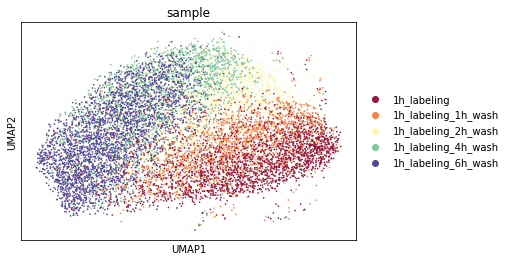

In [12]:
fig = sc.pl.umap(adata_, color='sample', show=False, palette={'1h_labeling': '#931A3C', '1h_labeling_1h_wash': '#F5824A', '1h_labeling_2h_wash': '#FCF6B9', '1h_labeling_4h_wash': '#80C699', '1h_labeling_6h_wash': '#554797'})
plt.savefig(os.path.join(ppath, 'figures', 'umap_timePoints.pdf'))

In [16]:
phate_exp = phate.PHATE(n_jobs=1, knn=30, decay=15, t='auto', gamma=1)
Y_phate = phate_exp.fit_transform(adata_)
phate_exp.set_params(n_components=3)
Y_phate_3d = phate_exp.transform()

In [ ]:
df_exp = pd.DataFrame(Y_phate_3d, columns=['x', 'y', 'z'])
df_exp['cell_cycle'] = adata_.obs['phase'].values
df_exp['orig_index'] = adata_.obs['orig_index'].values
df_exp['sample'] = adata_.obs['sample'].values
df_exp

x         y         z cell_cycle  orig_index  \
0     -0.013220  0.000366  0.000233         G1           0   
1     -0.011782  0.000040 -0.000630         G1           1   
2     -0.005662 -0.001314  0.000534        G2M           2   
3     -0.008118 -0.000690  0.000158        G2M           4   
4     -0.008153 -0.000847  0.000159         G1           5   
...         ...       ...       ...        ...         ...   
11071  0.022852  0.000238 -0.000041         G1        2563   
11072  0.038410  0.005027 -0.000003        G2M        2564   
11073 -0.004831 -0.001049 -0.000618          S        2565   
11074  0.007026 -0.001771 -0.001002          S        2566   
11075 -0.012049  0.000231 -0.000325          S        2568   

                    sample  
0      1h_labeling_2h_wash  
1      1h_labeling_2h_wash  
2      1h_labeling_2h_wash  
3      1h_labeling_2h_wash  
4      1h_labeling_2h_wash  
...                    ...  
11071          1h_labeling  
11072          1h_labeling  
11073          1h_labeling  
11074          1h_labeling  
11075          1h_labeling  

[11076 rows x 6 columns]

In [17]:
# color code
cc_col = {'G1': '#663399', 'S': '#FFD700', 'G2M': '#66CDAA'}
sam_col = {'1h_labeling': '#9e0142', '1h_labeling_1h_wash': '#f88d52', '1h_labeling_2h_wash': '#ffffbf', '1h_labeling_4h_wash': '#89d0a4', '1h_labeling_6h_wash': '#5e4fa2'}

In [13]:
# by cell cycle
fig = px.scatter_3d(df_exp, x='x', y='y', z='z', color='cell_cycle', color_discrete_map=cc_col, opacity=1, template='simple_white', custom_data=['orig_index', 'cell_cycle', 'sample']) #, color_discrete_map=cc_col
fig.update_traces(marker=dict(size=1.5, line=dict(width=0)), hovertemplate="<br>".join([
        "X: %{x}",
        "Y: %{y}",
        "Z: %{z}",
        "ind: %{customdata[0]}",
        "cc: %{customdata[1]}",
        "sam: %{customdata[2]}",
    ]))

In [21]:
# by time-points
fig = px.scatter_3d(df_exp, x='x', y='y', z='z', color='sample', color_discrete_map=sam_col, opacity=1, template='simple_white', custom_data=['orig_index', 'cell_cycle', 'sample']) #, color_discrete_map=cc_col
fig.update_traces(marker=dict(size=3, line=dict(width=0)), hovertemplate="<br>".join([
        "X: %{x}",
        "Y: %{y}",
        "Z: %{z}",
        "ind: %{customdata[0]}",
        "cc: %{customdata[1]}",
        "sam: %{customdata[2]}",
    ]))
fig.write_html('/stanley/WangLab/Connie/02.TEMPOmap/03.revision1000Gene/figures/phate.html')

test PHATE on cc well separated samples

In [12]:
# Load markers 
ppath = '/stanley/WangLab/Connie/02.TEMPOmap/03.revision1000Gene'
s_genes = pd.read_excel(os.path.join(ppath, 'cell_cycle_markers.xlsx'), sheet_name='G1_S', header=None)[0].to_list()
g2m_genes = pd.read_excel(os.path.join(ppath, 'cell_cycle_markers.xlsx'), sheet_name='G2_M', header=None)[0].to_list()
cell_cycle_genes = s_genes + g2m_genes

In [13]:
# Get cell cycle genes 
missed_genes = [x for x in cell_cycle_genes if x not in adata.var_names]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
s_genes_true = [x for x in s_genes if x in adata.var_names]
g2m_genes_true = [x for x in g2m_genes if x in adata.var_names]

print('cell cycle genes: ', len(cell_cycle_genes), '\nmissed genes: ', len(missed_genes))
print(f"G1/S genes: {len(s_genes)} - G2/M genes: {len(g2m_genes)}")
print(f"G1/S genes in our dataest: {len(s_genes_true)} - G2/M genes in our dataest: {len(g2m_genes_true)}")

cell cycle genes:  41 
missed genes:  0
G1/S genes: 19 - G2/M genes: 22
G1/S genes in our dataest: 19 - G2/M genes in our dataest: 22


         Falling back to preprocessing with `sc.pp.pca` and default params.


/local/scratch/36874112.1.interactive/ipykernel_20356/3568970056.py:9: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



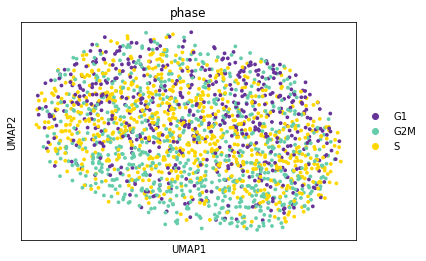

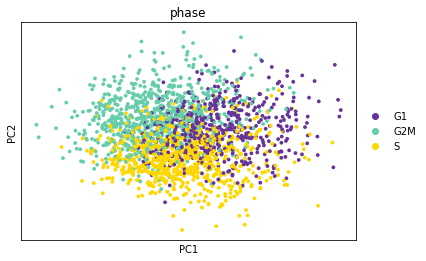

Calculating PHATE...
  Running PHATE on 2089 observations and 991 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.12 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.92 seconds.
    Calculating affinities...
    Calculated affinities in 0.93 seconds.
  Calculated graph and diffusion operator in 2.16 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 3.52 seconds.
    Calculating KMeans...
    Calculated KMeans in 6.37 seconds.
  Calculated landmark operator in 22.49 seconds.
  Calculating optimal t...
    Automatically selected t = 2
  Calculated optimal t in 2.75 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.21 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.89 seconds.
Calculated PHATE in 31.54 seconds.
Calculating metric MDS...
Calculated metric MDS in 46.09 seconds.


In [14]:
# STARmap
adata_star = adata[adata.obs['sample']=='STARmap',np.isin(adata.var.index, anchor, invert=True)]
# cc label
cc = []
star_obs = sample_adata['STARmap'].obs
for i in range(adata_star.n_obs):
    orig_index = adata_star.obs.iloc[i]['orig_index']
    cc.append(star_obs[star_obs['orig_index']==orig_index]['phase'].values[0])
adata_star.obs['phase'] = cc
# prep+umap
sc.pp.normalize_total(adata_star, target_sum=1e4)
sc.pp.log1p(adata_star)
sc.pp.scale(adata_star)
sc.pp.neighbors(adata_star, metric='euclidean', n_neighbors=15)
sc.tl.umap(adata_star, min_dist=0.5)
sc.pl.umap(adata_star, color='phase', palette={'G1': 'rebeccapurple', 'G2M': 'mediumaquamarine', 'S': 'gold'})
adata_cc_genes = adata_star[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')
phate_exp = phate.PHATE(n_jobs=1, knn=30, decay=15, t='auto', gamma=1)
Y_phate = phate_exp.fit_transform(adata_star)
phate_exp.set_params(n_components=3)
Y_phate_3d = phate_exp.transform()
df_exp = pd.DataFrame(Y_phate_3d, columns=['x', 'y', 'z'])
df_exp['cell_cycle'] = adata_star.obs['phase'].values
df_exp['orig_index'] = adata_star.obs['orig_index'].values
# by cell cycle
fig = px.scatter_3d(df_exp, x='x', y='y', z='z', color='cell_cycle', color_discrete_map=cc_col, opacity=1, template='simple_white', custom_data=['orig_index', 'cell_cycle']) 
fig.update_traces(marker=dict(size=1.5, line=dict(width=0)), hovertemplate="<br>".join([
        "X: %{x}",
        "Y: %{y}",
        "Z: %{z}",
        "ind: %{customdata[0]}",
        "cc: %{customdata[1]}"
    ]))

         Falling back to preprocessing with `sc.pp.pca` and default params.


/local/scratch/36874112.1.interactive/ipykernel_20356/2412430575.py:9: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.



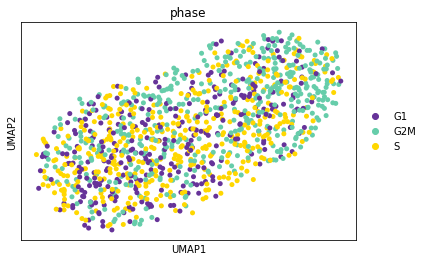

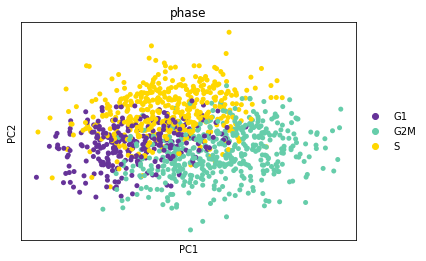

Calculating PHATE...
  Running PHATE on 1194 observations and 991 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.08 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.31 seconds.
    Calculating affinities...
    Calculated affinities in 0.29 seconds.
  Calculated graph and diffusion operator in 0.74 seconds.
  Calculating optimal t...
    Automatically selected t = 4
  Calculated optimal t in 0.94 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.13 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 1.47 seconds.
Calculated PHATE in 3.32 seconds.
Calculating metric MDS...
Calculated metric MDS in 35.11 seconds.


In [16]:
# 20h labeling
adata_20 = adata[adata.obs['sample']=='20h_labeling',np.isin(adata.var.index, anchor, invert=True)]
# cc label
cc = []
_obs = sample_adata['20h_labeling'].obs
for i in range(adata_20.n_obs):
    orig_index = adata_20.obs.iloc[i]['orig_index']
    cc.append(_obs[_obs['orig_index']==orig_index]['phase'].values[0])
adata_20.obs['phase'] = cc
# prep+umap
sc.pp.normalize_total(adata_20, target_sum=1e4)
sc.pp.log1p(adata_20)
sc.pp.scale(adata_20)
sc.pp.neighbors(adata_20, metric='euclidean', n_neighbors=15)
sc.tl.umap(adata_20, min_dist=0.5)
sc.pl.umap(adata_20, color='phase', palette={'G1': 'rebeccapurple', 'G2M': 'mediumaquamarine', 'S': 'gold'})
adata_cc_genes = adata_20[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')
phate_exp = phate.PHATE(n_jobs=1, knn=30, decay=15, t='auto', gamma=1)
Y_phate = phate_exp.fit_transform(adata_20)
phate_exp.set_params(n_components=3)
Y_phate_3d = phate_exp.transform()
df_exp = pd.DataFrame(Y_phate_3d, columns=['x', 'y', 'z'])
df_exp['cell_cycle'] = adata_20.obs['phase'].values
df_exp['orig_index'] = adata_20.obs['orig_index'].values
# by cell cycle
fig = px.scatter_3d(df_exp, x='x', y='y', z='z', color='cell_cycle', color_discrete_map=cc_col, opacity=1, template='simple_white', custom_data=['orig_index', 'cell_cycle']) 
fig.update_traces(marker=dict(size=1.5, line=dict(width=0)), hovertemplate="<br>".join([
        "X: %{x}",
        "Y: %{y}",
        "Z: %{z}",
        "ind: %{customdata[0]}",
        "cc: %{customdata[1]}"
    ]))